# Data Preparation & Exploration 

In [1]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%pylab inline
from datetime import datetime
import pickle 
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
import shap

pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
TODO = 5000
train = pd.read_pickle("train_set.pickle").sample(n=TODO)
train.loc[:,"clicked"] = train.loc[:,"clicked"].map({True:1, False:0})



In [4]:

#TODO replace with Ayelet code
train.loc[:,'time'] = pd.to_datetime(train['timestamp'], unit='s')
train.loc[:,'Day_of_Week'] = train['time'].dt.weekday_name

# note monday == 0 
train.loc[:,'weekend'] = train['time'].dt.dayofweek > 4

train.loc[:,'Month'] = train['time'].dt.month_name().str[:3]
train.loc[:,'hour'] = train['time'].dt.hour

train.loc[:,'device_diag'] = np.sqrt(train.device_height^2 + train.device_width^2).round()
train.loc[:,'manufacturer'] = train['manufacturer'].fillna('Unknown')

In [5]:
train_df, other = train_test_split(train, test_size=0.3, random_state=42)
dev_val, other2 = train_test_split(other, test_size=2/3, random_state=42)
dev_test, dev_es = train_test_split(other2, test_size=0.5, random_state=42)

In [6]:
train_df.shape, dev_val.shape, dev_es.shape, dev_test.shape

((3500, 18), (500, 18), (500, 18), (500, 18))

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 323301 to 2502926
Data columns (total 18 columns):
timestamp         3500 non-null int64
state             3500 non-null object
user_isp          3500 non-null object
app_id            3500 non-null object
app_cat           3500 non-null object
banner_pos        3500 non-null object
manufacturer      3500 non-null object
device_model      2425 non-null object
device_version    3500 non-null object
device_height     3500 non-null int64
device_width      3500 non-null int64
clicked           3500 non-null int64
time              3500 non-null datetime64[ns]
Day_of_Week       3500 non-null object
weekend           3500 non-null bool
Month             3500 non-null object
hour              3500 non-null int64
device_diag       3500 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(10)
memory usage: 495.6+ KB


In [8]:
# TODO update features list
features = ['app_cat', 'banner_pos', 'device_diag', 'state' , 'Day_of_Week', 'Month', 'hour' , 'device_version' , 'manufacturer']
cat_features = ['app_cat','banner_pos','state' ,  'Day_of_Week', 'Month', 'hour','device_version' , 'manufacturer']

In [9]:
X_train = train_df[features]
y_train = train_df['clicked']
X_val = dev_val[features]
y_val = dev_val['clicked']
X_es  = dev_es[features]
y_es = dev_es['clicked']

# exploring the Target Encoder

In [10]:
encoder = ce.TargetEncoder(cols=cat_features)
encoder.fit(X_train, y_train)


TargetEncoder(cols=['app_cat', 'banner_pos', 'state', 'Day_of_Week', 'Month',
                    'hour', 'device_version', 'manufacturer'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=1.0, verbose=0)

In [11]:
X_val_encoded = encoder.fit_transform(X_val, y_val)

In [12]:
X_val_encoded.describe()

,app_cat,banner_pos,device_diag,state,Day_of_Week,Month,hour,device_version,manufacturer
count,5.000000e+02,500.000000,500.000000,5.000000e+02,500.000000,500.000000,5.000000e+02,500.000000,500.000000
mean,5.902865e-02,0.060000,40.980000,5.816544e-02,0.060000,0.060043,6.000375e-02,0.059978,0.061067
std,4.224592e-02,0.064272,9.552282,6.460524e-02,0.022144,0.014996,5.857927e-02,0.040004,0.046847
min,2.065015e-15,0.000000,26.000000,1.673681e-11,0.023810,0.007152,3.996803e-17,0.000003,0.002846
25%,2.500000e-02,0.000000,31.000000,2.012101e-05,0.034483,0.040984,1.835413e-08,0.037037,0.043750
50%,4.838710e-02,0.000000,45.000000,5.952381e-02,0.070423,0.066667,6.060606e-02,0.054545,0.050420
75%,9.523810e-02,0.138462,45.000000,6.451613e-02,0.078652,0.072626,9.677419e-02,0.054545,0.066038
max,1.818127e-01,0.147541,64.000000,3.816658e-01,0.087719,0.072626,2.142857e-01,0.331504,0.374713


# Preparing for pipeline creation

In [13]:
def plot_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

In [14]:

def plot_calibration(y, y_hat):
    # reliability diagram
    fop, mpv = calibration_curve(y, y_hat, n_bins=10, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.plot(mpv, fop, marker='.')
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("True Probabilities")
    plt.title("Calibration Curve")
    pyplot.show()

In [15]:
def find_threshold(y, y_hat):
    num_actual_clicks = sum(y)
    threshold = 0.5
    num_predicted_clicks = sum(y[y_hat>=threshold])
    while num_predicted_clicks < num_actual_clicks:
        threshold = threshold - 0.01
        num_predicted_clicks = sum(y[y_hat>=threshold])
        #print (f"""threshold:{threshold}, num_predicted_clicks:{num_predicted_clicks}""")
    
    return threshold

In [16]:
def find_threshold_by_accuracy(y, y_hat, plot=False):
    threshold = []
    accuracy = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_accuracy = accuracy_score(y,y_pred)
        accuracy.append(curr_accuracy)
    best_threshold = threshold[np.argmax(np.array(accuracy), axis=0)]
    best_accuracy = max(accuracy)
    print ("Best Threshold:" ,best_threshold, ", with accuracy = ", best_accuracy)
    if plot:
        plt.scatter(threshold,accuracy)
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.show()
    return best_accuracy, best_threshold

In [17]:
def find_threshold_by_logloss(y, y_hat, plot=False):
    threshold = []
    logloss = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_logloss = -log_loss(y,y_pred)
        logloss.append(curr_logloss)
    best_threshold = threshold[np.argmax(np.array(logloss), axis=0)]
    best_logloss = max(logloss)
    print ("Best Threshold:" ,best_threshold, ", with logloss = ", best_logloss)
    return best_logloss, best_threshold

In [18]:

def find_best_params_random_forest(grid, X_train, y_train, X_val, y_val):
    best_accuracy = 0
    worst_accuracy = 1
    for g in ParameterGrid(grid):
        print(g)
        rf_pipe = make_rf_pipe_line(None, params = g)
        rf_pipe.fit(X_train,y_train)
        y_hat = rf_pipe.predict_proba(X_val)[:,1]
        curr_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_grid = g
            
        if curr_accuracy < worst_accuracy:
            worst_accuracy = curr_accuracy
            worst_grid = g
    print ("Final Result")
    print ("best accuracy", best_accuracy, ", Grid:", best_grid)
    print ("worst accuracy", worst_accuracy, ", Grid:", best_grid)
    return best_grid

In [19]:
def evaulate_pipeline(pipe, X, y):
    y_hat = pipe.predict_proba(X)[:,1]
    assert y.shape ==  y_hat.shape
    best_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)
    
    y_pred = (y_hat >= best_threshold).astype(int)

 
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
    auc = plot_auc(fpr, tpr)
    plot_calibration(y, y_hat)
    #plt.hist(y_hat[y_hat >= 0], bins=10, density=False)
    plt.hist(y_hat, bins=100, density=True)
    plt.title("Histogram of predicted probabilities for click")
    plt.show()
    #threshold = find_threshold(y, y_hat)
    #print (f"""threshold={threshold:.2f}, num clicks: predicted={sum(y[y_hat>=threshold])}, actual={sum(y)}""")
    print("Accuracy:", accuracy_score(y, y_pred, normalize=True))
    print("Recall:", recall_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("AUC:", auc)
    #print("-logloss:", -log_loss(y, y_hat))
    

# Random Forest PipeLine

In [20]:
def make_rf_pipe_line(calibration = None, params = None ):
    assert calibration is None or calibration in ['isotonic', 'sigmoid']
    encoder = ce.TargetEncoder(cols=cat_features)
    rf = RandomForestClassifier(n_estimators = 200, max_depth=5, criterion = "gini", n_jobs = 4,
                                min_samples_split=100,random_state=13)
    if params:
        rf.set_params(**params)
    if calibration is None:
        rf_pipe = Pipeline([('target_enc',encoder),  ('classifier', rf)])
    else:
        calibrated_RF_classifier =  CalibratedClassifierCV(base_estimator=rf, cv=5, method=calibration)
        rf_pipe = Pipeline([('target_enc',encoder),  ('calibrated_classifier', calibrated_RF_classifier)])
    rf_pipe.fit(X_train, y_train)
    return rf_pipe


In [21]:
%%time

rf_params_grid ={'min_samples_leaf': [100], 
                 'max_depth': [4] ,
                 'class_weight' : ['balanced'],
                 'n_estimators': [100],
                 'criterion': ["gini"]
                 
                }
best_rf_params = find_best_params_random_forest(rf_params_grid, X_train, y_train, X_val, y_val)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 100, 'n_estimators': 100}
Best Threshold: 0.7342646036508921 , with accuracy =  0.938
Final Result
best accuracy 0.938 , Grid: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 100, 'n_estimators': 100}
worst accuracy 0.938 , Grid: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 100, 'n_estimators': 100}
Wall time: 1.1 s


In [22]:

rf_pipe = make_rf_pipe_line(calibration = None, params = best_rf_params)


Best Threshold: 0.7342646036508923 , with accuracy =  0.938


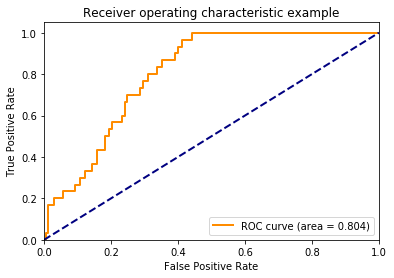

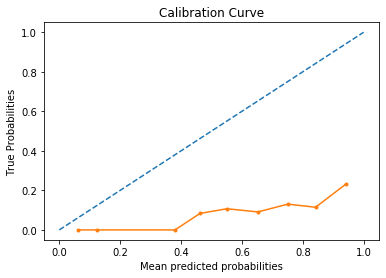

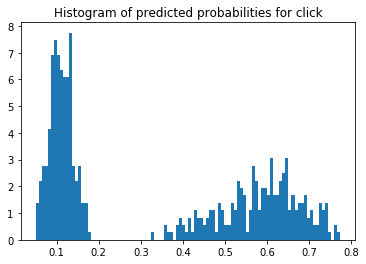

Accuracy: 0.938
Recall: 0.16666666666666666
Precision: 0.45454545454545453
AUC: 0.8041843971631205


In [23]:

evaulate_pipeline(rf_pipe, X_val, y_val)

# Cat Boost Model

In [24]:
validation_pool = Pool(data = X_val, label = y_val, cat_features=cat_features)
train_pool = Pool(data = X_train, label = y_train, cat_features=cat_features)
es_pool = Pool(data = X_es, label = y_es, cat_features=cat_features)


In [25]:
def make_catboost_pipe_line(train_pool, es_pool, class_weight = None, target_encoder = False, params = None):
    model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               custom_loss = ['AUC', 'Logloss','BrierScore', 'Precision', 'Recall'],
                               early_stopping_rounds = 20,
                               auto_class_weights = class_weight,
                               subsample= 0.5,
                               verbose=30)
    if params:
        model.set_params(**params)
    model.fit(train_pool, eval_set=es_pool, plot=True)
    return model


In [26]:
catboost_params_grid ={ 'depth': [4,6,8] ,
                 'min_child_samples' : [100,500,1000],
                 'n_estimators': [100,200],
                  'subsample': [0.5,0.75,0.95],
                       
                }
#find_best_params_catboost(catboost_params_grid, train_pool, es_pool, X_val, y_val)

In [27]:
model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               early_stopping_rounds = 20,
                               auto_class_weights = 'Balanced',
                               subsample= 0.5,
                               verbose=30)
search_results = model.randomized_search(catboost_params_grid,
                  train_pool,
                  y=None,
                  cv=3,
                  n_iter=10,
                  partition_random_seed=0,
                  calc_cv_statistics=True,
                  search_by_train_test_split=True,
                  refit=True,
                  shuffle=True,
                  stratified=None,
                  train_size=0.8,
                  verbose=False,
                  log_cout=sys.stdout,
                  log_cerr=sys.stderr)

0:	learn: 0.6728454	test: 0.6717880	best: 0.6717880 (0)	total: 67.2ms	remaining: 13.4s
30:	learn: 0.4948928	test: 0.4858215	best: 0.4858215 (30)	total: 367ms	remaining: 2s
60:	learn: 0.4703890	test: 0.4640898	best: 0.4640898 (60)	total: 617ms	remaining: 1.41s
90:	learn: 0.4595532	test: 0.4588344	best: 0.4588344 (90)	total: 961ms	remaining: 1.15s
120:	learn: 0.4479433	test: 0.4559847	best: 0.4559847 (120)	total: 1.25s	remaining: 816ms
150:	learn: 0.4403506	test: 0.4529016	best: 0.4529016 (150)	total: 1.53s	remaining: 498ms
180:	learn: 0.4314567	test: 0.4495179	best: 0.4495179 (180)	total: 1.78s	remaining: 187ms
199:	learn: 0.4266141	test: 0.4485938	best: 0.4484647 (198)	total: 1.96s	remaining: 0us

bestTest = 0.4484646535
bestIteration = 198

0:	learn: 0.6711623	test: 0.6701612	best: 0.6701612 (0)	total: 17ms	remaining: 1.68s
30:	learn: 0.4904635	test: 0.4840096	best: 0.4840096 (30)	total: 278ms	remaining: 618ms
60:	learn: 0.4703583	test: 0.4657047	best: 0.4657047 (60)	total: 459ms	rema

### optimized configuration for catboost

In [28]:
search_results['params']

{'min_data_in_leaf': 1000, 'depth': 4, 'iterations': 200, 'subsample': 0.95}

### Train a final cat boost model with the optimized params

In [29]:
catboost_pipe = make_catboost_pipe_line(train_pool, es_pool, target_encoder = False, params = search_results['params'])


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.086965
0:	learn: 0.5970098	test: 0.5978828	best: 0.5978828 (0)	total: 10.6ms	remaining: 2.11s
30:	learn: 0.1859729	test: 0.1936703	best: 0.1936703 (30)	total: 248ms	remaining: 1.35s
60:	learn: 0.1762069	test: 0.1928143	best: 0.1917317 (56)	total: 596ms	remaining: 1.36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1917317141
bestIteration = 56

Shrink model to first 57 iterations.


Best Threshold: 0.2181606359997792 , with accuracy =  0.938


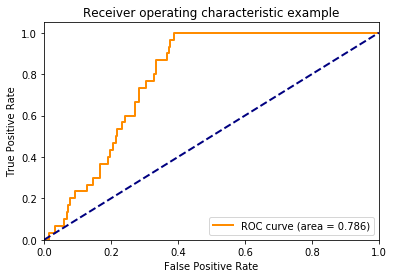

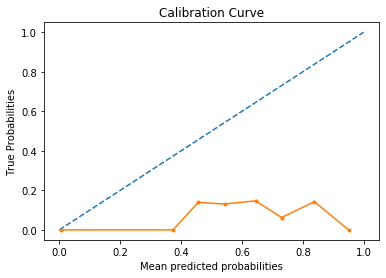

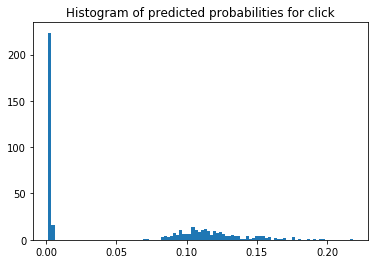

Accuracy: 0.938
Recall: 0.0
Precision: 0.0
AUC: 0.7855319148936171


In [30]:
evaulate_pipeline(catboost_pipe, X_val, y_val)

# KNN Classifier Model

In [31]:
def make_knn_pipe_line(params = None) :
    encoder = ce.TargetEncoder(cols=cat_features)
    knn_model = KNeighborsClassifier(n_neighbors=300, weights='uniform')
    if params:
        knn_model.set_params(**params)
    return (Pipeline([('target_enc',encoder),  ('scaler',  StandardScaler()), ('KNN', knn_model)]))   

In [32]:
def find_best_params_knn(grid,X_train, y_train, X_val, y_val):
    best_accuracy = 0
    worst_accuracy = 1
    for g in ParameterGrid(grid):
        print(g)
        model = make_knn_pipe_line(params = g)
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_val)[:,1]
        curr_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_grid = g
            
        if curr_accuracy < worst_accuracy:
            worst_accuracy = curr_accuracy
            worst_grid = g
    print ("Final Result")
    print ("best accuracy", best_accuracy, ", Grid:", best_grid)
    print ("worst accuracy", worst_accuracy, ", Grid:", best_grid)
    return best_grid

In [ ]:
%%time

knn_params_grid ={'n_neighbors': [100, 500, 1000], 
                 'weights': ['uniform' , 'distance'],
                  'leaf_size' : [30,100]
                }
best_knn_params = find_best_params_knn(knn_params_grid, X_train, y_train, X_val, y_val)

{'leaf_size': 30, 'n_neighbors': 100, 'weights': 'uniform'}


In [ ]:
knn_pipeline = make_knn_pipe_line(params = best_knn_params)
knn_pipeline.fit(X_train, y_train)

In [ ]:
evaulate_pipeline(knn_pipeline, X_val, y_val)

# Shap Values

In [ ]:
model = catboost_pipe


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.initjs()


Shap Values (Shapely Additive exPlanations is a model Agnostic method for explaining model predictions
It is based on theory developed by Loid Shapley in the 1950's 

# Shap Summary Plot

In [ ]:

shap.summary_plot(shap_values)

In [ ]:

def explain_simple(idx, X_train):
    data = X_train.iloc[[idx]]
    shap_values = explainer.shap_values( data)
    return (shap.force_plot(explainer.expected_value,shap_values , data, link='logit'))

# 3 random prediction explanations

In [ ]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [ ]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [ ]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)